# Modelagem Estatística

### Banco de 2021

Para a modelagem estatística, irei utilizar uma árvore de decisão pois acredito ser a melhor opção para visualizar quais variáveis são mais e menos importantes na hora de determinar o óbito.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
plt.rcParams['figure.figsize'] = 25, 10

In [3]:
df = pd.read_csv('SRAG_2020_2021.csv', parse_dates=['DT_NOTIFIC'])

In [3]:
df.shape

(2261067, 51)

In [4]:
df.columns

Index(['DT_NOTIFIC', 'tempo_alta_obito_final', 'febre', 'tosse', 'dispneia',
       'diarreia', 'vomito', 'garganta', 'desc_resp', 'saturacao', 'dor_abd',
       'fadiga', 'perd_olft', 'perd_pala', 'hematologi', 'cardiopati', 'asma',
       'diabetes', 'pneumopati', 'renal', 'imunodepre', 'hepatica',
       'neurologic', 'obesidade', 'puerpera', 'sind_down', 'SG_UF_NOT',
       'idade', 'CS_SEXO', 'gravidez', 'raca', 'vacina_gripe', 'mae_amamenta',
       'mae_vacinada_gripe', 'EVOLUCAO', 'diagnostico', 'antiviral',
       'suporte_vent', 'uti', 'positivo_vsr', 'positivo_para1',
       'positivo_para2', 'positivo_para3', 'positivo_para4', 'positivo_adeno',
       'positivo_sars2', 'positivo_influenza', 'positivo_metap',
       'positivo_boca', 'positivo_rino', 'vacina_covid19'],
      dtype='object')

In [5]:
for i in df.columns:
    print('Coluna: ', i, '\nTipo: ', type(df[i][0]))
    print('')

Coluna:  DT_NOTIFIC 
Tipo:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Coluna:  tempo_alta_obito_final 
Tipo:  <class 'numpy.float64'>

Coluna:  febre 
Tipo:  <class 'str'>

Coluna:  tosse 
Tipo:  <class 'str'>

Coluna:  dispneia 
Tipo:  <class 'str'>

Coluna:  diarreia 
Tipo:  <class 'str'>

Coluna:  vomito 
Tipo:  <class 'str'>

Coluna:  garganta 
Tipo:  <class 'str'>

Coluna:  desc_resp 
Tipo:  <class 'str'>

Coluna:  saturacao 
Tipo:  <class 'str'>

Coluna:  dor_abd 
Tipo:  <class 'str'>

Coluna:  fadiga 
Tipo:  <class 'str'>

Coluna:  perd_olft 
Tipo:  <class 'str'>

Coluna:  perd_pala 
Tipo:  <class 'str'>

Coluna:  hematologi 
Tipo:  <class 'str'>

Coluna:  cardiopati 
Tipo:  <class 'str'>

Coluna:  asma 
Tipo:  <class 'str'>

Coluna:  diabetes 
Tipo:  <class 'str'>

Coluna:  pneumopati 
Tipo:  <class 'str'>

Coluna:  renal 
Tipo:  <class 'str'>

Coluna:  imunodepre 
Tipo:  <class 'str'>

Coluna:  hepatica 
Tipo:  <class 'str'>

Coluna:  neurologic 
Tipo:  <class 'str'>

## Seleção das variáveis numéricas e categóricas

Também irei retirar algumas variáveis da análise, como Raça e Estado

In [10]:
delete_vars = ['raca', 'SG_UF_NOT', 'EVOLUCAO', 'DT_NOTIFIC']
num_vars = ['tempo_alta_obito_final', 'idade']
dummy_vars = ['gravidez', 'mae_amamenta', 'mae_vacinada_gripe', 'positivo_vsr', 'positivo_para1', 'positivo_para2', 
              'positivo_para3', 'positivo_para4', 'positivo_adeno', 'positivo_sars2', 'positivo_influenza', 'positivo_metap',
             'positivo_boca', 'positivo_rino']

cat_vars = [i for i in df.columns if (i not in delete_vars) and (i not in num_vars) and (i not in dummy_vars)]

model_vars = cat_vars + num_vars + dummy_vars

In [7]:
len(model_vars)

47

### Separando em treino e teste (OOT)

O banco de teste será OOT (Out of time). Pode-se ver pela variável DT_NOTIFIC que o banco vai de 29/12/2019 até 09/12/2021 (provável erro). Vou utilizar como treino os casos do início até 31 de junho de 2021. A partir de 01 de julho de 2021 será utilizado como teste (OOT).

Essa divisão traz uma proporção de, aproximadamente 19,7% para teste

In [8]:
df[['DT_NOTIFIC']].describe(datetime_is_numeric=True)

,DT_NOTIFIC
count,2261067
mean,2021-01-07 20:22:27.490544384
min,2019-12-29 00:00:00
25%,2020-08-09 00:00:00
50%,2021-02-04 00:00:00
75%,2021-05-23 00:00:00
max,2021-12-09 00:00:00


In [11]:
data_corte = pd.to_datetime('2021-07-01')

df_train = df[df['DT_NOTIFIC'] <= data_corte].reset_index().copy()
df_test = df[df['DT_NOTIFIC'] >= data_corte].reset_index().copy()

In [12]:
df_train.shape, df_test.shape

((1893438, 52), (372403, 52))

In [13]:
X_train = df_train[model_vars].copy()
y_train = df_train['EVOLUCAO'].copy()

X_test = df_test[model_vars].copy()
y_test = df_test['EVOLUCAO'].copy()

In [12]:
y_train.value_counts(normalize=True)

0    0.689948
1    0.310052
Name: EVOLUCAO, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

0    0.700271
1    0.299729
Name: EVOLUCAO, dtype: float64

A proporção entre 0 e 1 de teste e treino é próxima.

## Modelagem - Árvore de decisão

Inicialmente vou testar qual a max_depth que traz a maior acurácia para o modelo. Vou treinar vários modelos para plotar o gráfico de acurácia no teste

In [14]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

Para não ter que aplicar em cada loop a transformação das colunas categóricas em dummy, vou fazer o processo apenas 1 vez e aplicar no modelo

In [15]:
onehot = OneHotEncoder()

In [16]:
X_train_transf = onehot.fit_transform(X_train)

X_test_transf = onehot.transform(X_test)

C:\Users\guilh\anaconda3\envs\fia-tcc\lib\site-packages\feature_engine\encoding\one_hot.py:276: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


### Baseline - Modelo sem ajuste de hiperparâmetros

In [32]:
dt = Pipeline(steps=[
    # ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [33]:
dt.fit(X_train_transf, y_train)

Pipeline(steps=[('dt', DecisionTreeClassifier(random_state=42))])

## Avaliação do modelo

### Acurácia

In [34]:
y_pred_train = dt.predict(X_train_transf)
y_pred_test = dt.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.9997089949604898
Acurácia Teste: 0.7244195132692272


### AUROC

In [35]:
from sklearn.metrics import roc_auc_score

y_proba = dt.predict_proba(X_train_transf)[:, 1]

y_proba_test = dt.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.9999997996162251
AUC Teste: 0.6832462164858212


### Confusion Matrix

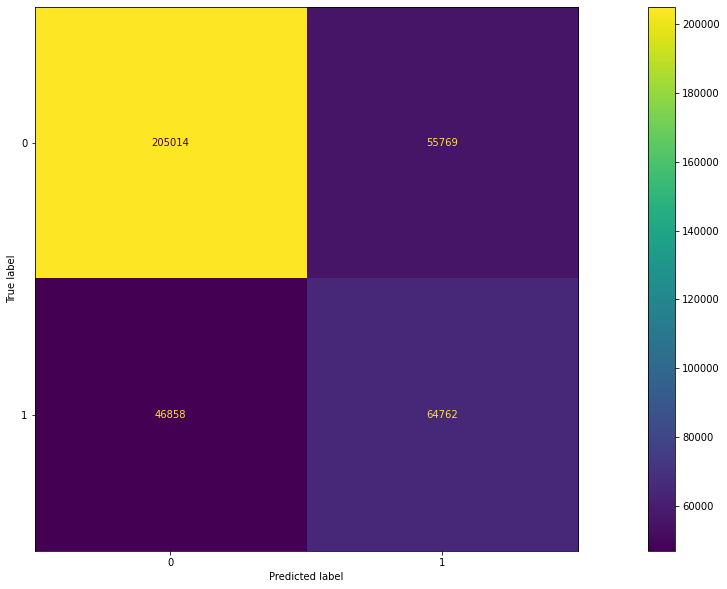

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.81      0.79      0.80    260783
       Obito       0.54      0.58      0.56    111620

    accuracy                           0.72    372403
   macro avg       0.68      0.68      0.68    372403
weighted avg       0.73      0.72      0.73    372403



## Feature Importances

Entendendo quais são as características que não podem faltar na triagem de um paciente com suspeita de SRAG

In [38]:
pd.set_option('display.max_rows', 140)

feature_importances_df = pd.DataFrame({
    'features': X_train_transf.columns,
    'importances': dt.steps[-1][1].feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df

,features,importances
127,suporte_vent_Invasivo,0.179608
0,tempo_alta_obito_final,0.166206
1,idade,0.158644
131,uti_Nao,0.029665
121,diagnostico_COVID,0.013354
11,positivo_sars2,0.011738
117,vacina_gripe_Ignorado,0.011029
16,febre_Sim,0.010833
114,vacina_gripe_Nao,0.010712
122,antiviral_Nao,0.010587


In [39]:
pd.reset_option('display.max_rows')

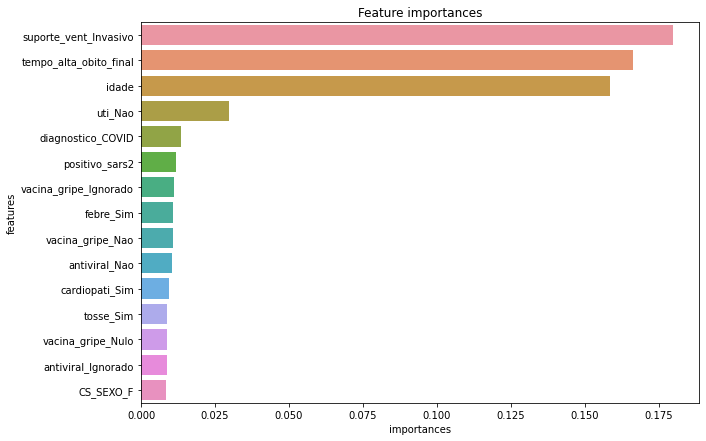

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.title("Feature importances")
sns.barplot(data = feature_importances_df[:15], x = 'importances', y = 'features')
plt.show()

In [ ]:
import shap

explainer = shap.Explainer(dt.steps[-1][1])
shap_values = explainer(X_test_transf)

shap.plots.beeswarm(shap_values[:, :, 1], max_display = 20)

### Modelo com ajuste de hiperparâmetros

Avaliação da profundidade da árvore e a acurácia do modelo

In [28]:
%%time

profundidade = []
acuracia = []

for depth in range(1, 31):
    dt = Pipeline(steps=[
        # ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
        ('dt', DecisionTreeClassifier(random_state=42, max_depth=depth))
    ])
    
    dt.fit(X_train_transf, y_train)
    
    y_pred_test = dt.predict(X_test_transf)
    accuracy = accuracy_score(y_test, y_pred_test)
    
    profundidade.append(depth)
    acuracia.append(accuracy)
    
    print('Profundidade:', depth, '\nAcurácia:', accuracy)
    print('')

Profundidade: 1 
Acurácia: 0.7858771277352761

Profundidade: 2 
Acurácia: 0.7858771277352761

Profundidade: 3 
Acurácia: 0.7894163043799325

Profundidade: 4 
Acurácia: 0.7986750912318107

Profundidade: 5 
Acurácia: 0.8017443468500522

Profundidade: 6 
Acurácia: 0.8041181193491996

Profundidade: 7 
Acurácia: 0.8060944729231505

Profundidade: 8 
Acurácia: 0.8072733033837

Profundidade: 9 
Acurácia: 0.8079553601877536

Profundidade: 10 
Acurácia: 0.8087716801422116

Profundidade: 11 
Acurácia: 0.8090402064430201

Profundidade: 12 
Acurácia: 0.8092684537987073

Profundidade: 13 
Acurácia: 0.8090375211800119

Profundidade: 14 
Acurácia: 0.8077969296702766

Profundidade: 15 
Acurácia: 0.8065294855304603

Profundidade: 16 
Acurácia: 0.8043356256528545

Profundidade: 17 
Acurácia: 0.8020262994659012

Profundidade: 18 
Acurácia: 0.7981111860001128

Profundidade: 19 
Acurácia: 0.794375985155866

Profundidade: 20 
Acurácia: 0.7904581864270696

Profundidade: 21 
Acurácia: 0.7869431771494859

Profu

In [41]:
result_profundidade = pd.DataFrame(profundidade, columns=['Profundidade'])
result_profundidade['Acuracia'] = acuracia
result_profundidade

,Profundidade,Acuracia
0,1,0.785877
1,2,0.785877
2,3,0.789416
3,4,0.798675
4,5,0.801744
5,6,0.804118
6,7,0.806094
7,8,0.807273
8,9,0.807955
9,10,0.808772


Salvando para não precisar rodar novamente

In [43]:
result_profundidade.to_csv('resultados_loop_profundidade.csv')

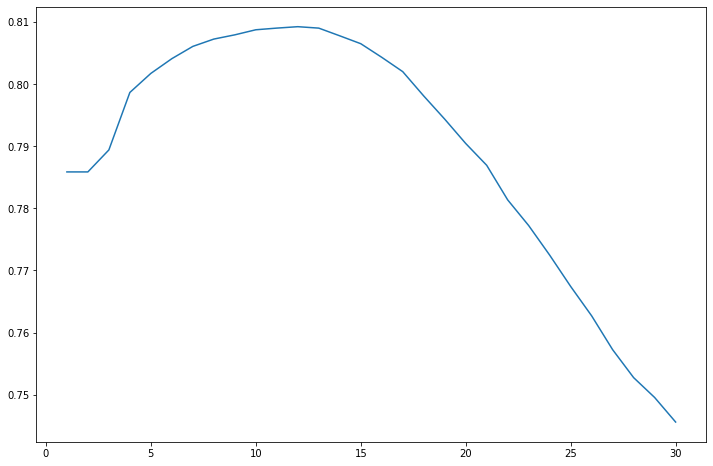

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
sns.lineplot(x = profundidade, y = acuracia)
plt.show()

Descobrindo o valor de profundidade que traz a maior acurácia

In [37]:
print('Maior acurácia:', max(acuracia), '\nProfundidade:', acuracia.index(max(acuracia))+1)

Maior acurácia: 0.8092684537987073 
Profundidade: 12


Apesar da profundidade 12 ser a árvore com melhor acurácia, o banco é muito grande e esta profundidade dificulta a plotagem da árvore e sua interpretação. Com isso em mente, vou montar o modelo com 7 de profundidade. Além disso, como o banco de dados tem muitas linhas, testarei 10 possibilidades de min_samples_leaf, de 2 a 1000 de 100 em 100 para ver se há alteração na acurácia. O aumento do min_samples_leaf faz com que a árvore diminua suas quebras, já que precisa que mais amostras para realizar uma quebra.

In [109]:
%%time

samp_leaf = [2, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

acuracia = []

for samples_leaf in samp_leaf:
    dt = Pipeline(steps=[
        # ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
        ('dt', DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=samples_leaf))
    ])
    
    dt.fit(X_train_transf, y_train)
    
    y_pred_test = dt.predict(X_test_transf)
    accuracy = accuracy_score(y_test, y_pred_test)
    
    acuracia.append(accuracy)
    
    print('min_samples_leaf:', samples_leaf, '\nAcurácia:', accuracy)
    print('')

min_samples_leaf: 2 
Acurácia: 0.8060971581861586

min_samples_leaf: 100 
Acurácia: 0.8060756760820939

min_samples_leaf: 200 
Acurácia: 0.8060595645040454

min_samples_leaf: 300 
Acurácia: 0.8059736360877866

min_samples_leaf: 400 
Acurácia: 0.805799093992261

min_samples_leaf: 500 
Acurácia: 0.8058071497812853

min_samples_leaf: 600 
Acurácia: 0.8057776118881964

min_samples_leaf: 700 
Acurácia: 0.8056514045268164

min_samples_leaf: 800 
Acurácia: 0.8056191813707193

min_samples_leaf: 900 
Acurácia: 0.8056889982089296

min_samples_leaf: 1000 
Acurácia: 0.805578902425598

Wall time: 5min 47s


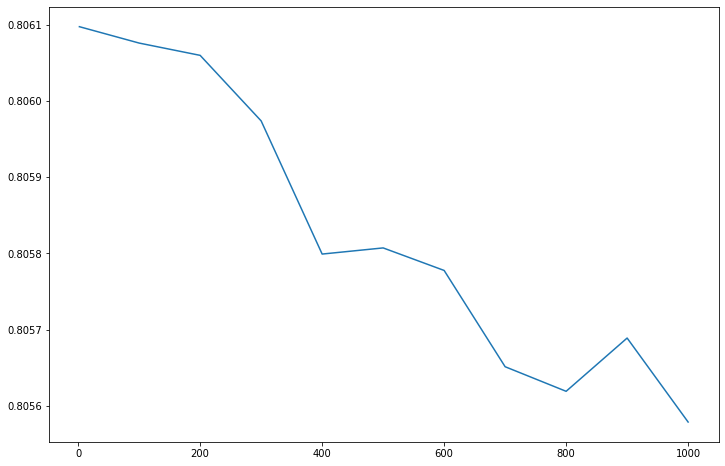

In [111]:
plt.figure(figsize = (12,8))
sns.lineplot(x = samp_leaf, y = acuracia)
plt.show()

Como a acurácia vai descendo com o aumento do min_samples_leaf, vou utilizar 100 para diminuir o tamanho da árvore que será plotada.

In [17]:
dt = Pipeline(steps=[
    # ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=1000))
])

In [18]:
dt.fit(X_train_transf, y_train)

Pipeline(steps=[('dt',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=1000,
                                        random_state=42))])

## Avaliação do modelo

### Acurácia

In [19]:
y_pred_train = dt.predict(X_train_transf)
y_pred_test = dt.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.7956326005921504
Acurácia Teste: 0.805578902425598


### AUROC

In [20]:
from sklearn.metrics import roc_auc_score

y_proba = dt.predict_proba(X_train_transf)[:, 1]

y_proba_test = dt.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.836730302625145
AUC Teste: 0.8442652829805808


### Confusion Matrix

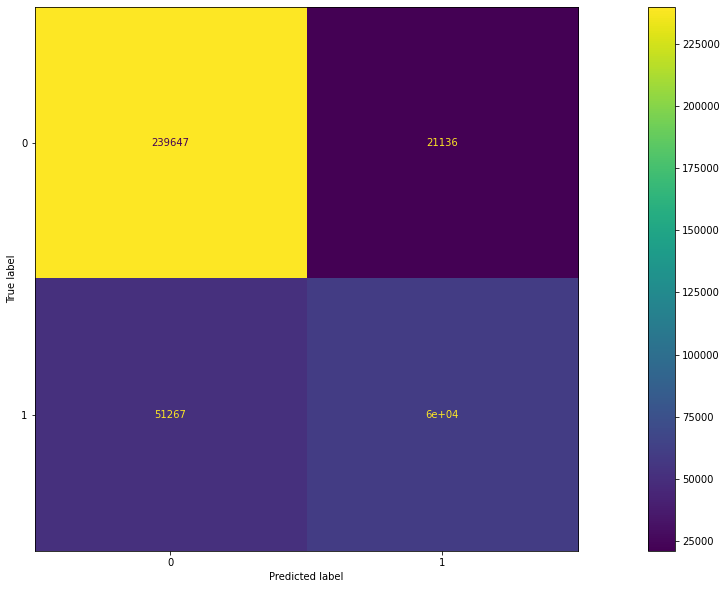

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.82      0.92      0.87    260783
       Obito       0.74      0.54      0.63    111620

    accuracy                           0.81    372403
   macro avg       0.78      0.73      0.75    372403
weighted avg       0.80      0.81      0.80    372403



## Feature Importances

Entendendo quais são as características que não podem faltar na triagem de um paciente com suspeita de SRAG

In [23]:
pd.set_option('display.max_rows', 140)

feature_importances_df = pd.DataFrame({
    'features': X_train_transf.columns,
    'importances': dt.steps[-1][1].feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df

,features,importances
127,suporte_vent_Invasivo,0.550400
1,idade,0.271910
131,uti_Nao,0.088796
121,diagnostico_COVID,0.036164
0,tempo_alta_obito_final,0.034204
128,suporte_vent_Nao,0.006456
132,uti_Sim,0.001757
100,obesidade_Nulo,0.001596
40,desc_resp_Sim,0.001413
20,tosse_Sim,0.001308


In [24]:
pd.reset_option('display.max_rows')

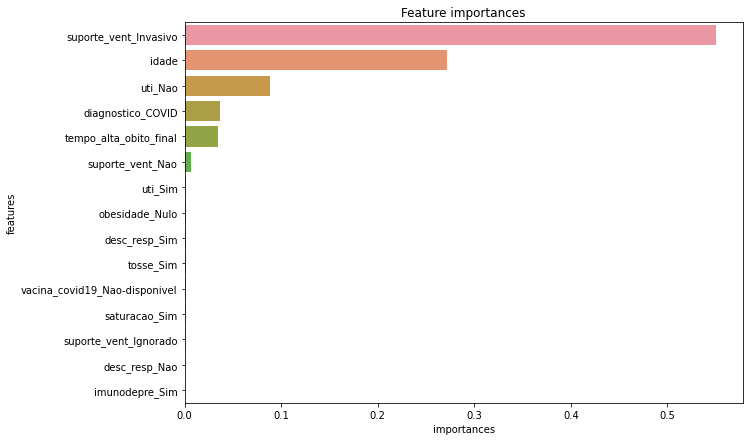

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.title("Feature importances")
sns.barplot(data = feature_importances_df[:15], x = 'importances', y = 'features')
plt.show()

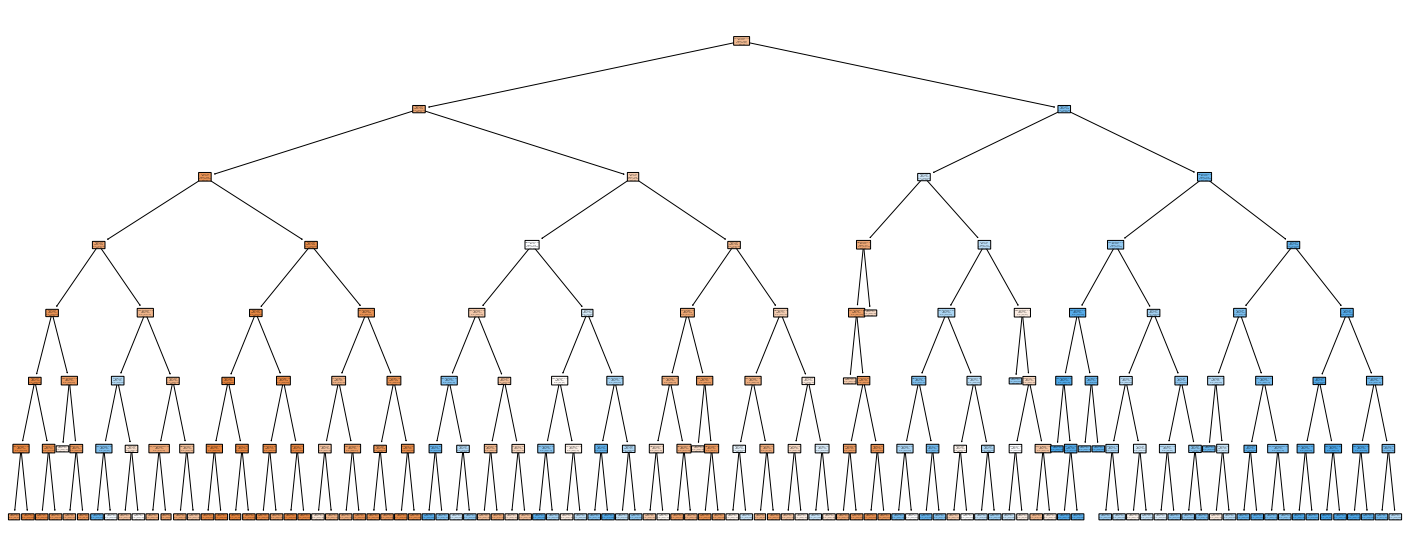

In [26]:
plot_tree(
    dt.steps[-1][1],
    feature_names=X_train_transf.columns,
    class_names=['Alta', 'Obito'],
    rounded=True,
    filled=True,
    proportion=True
);

plt.savefig('tree_7_1000.pdf',format='pdf')

In [28]:
df.shape

(2261067, 51)

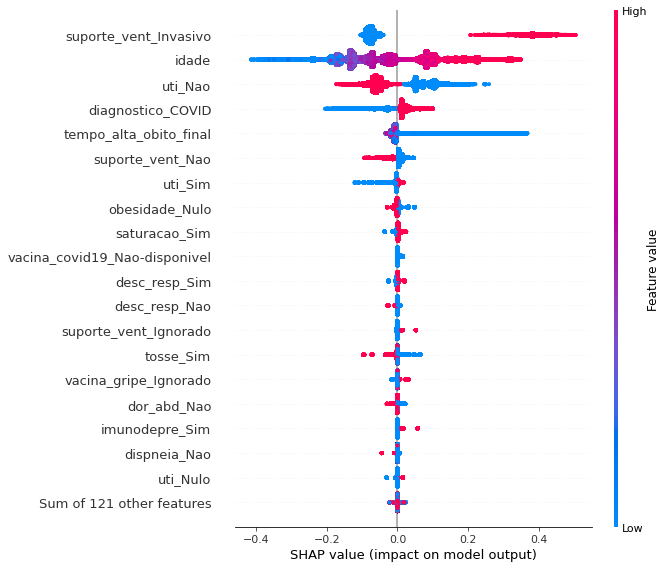

In [27]:
import shap

explainer = shap.Explainer(dt.steps[-1][1])
shap_values = explainer(X_test_transf)

shap.plots.beeswarm(shap_values[:, :, 1], max_display = 20) # 1 é o óbito e 0 a alta

## Alterando o ponto de corte do modelo

Para isso, vou utilizar o ROC através de uma função que irá retornar o ponto de corte ótimo que tem alta taxa de verdadeiros positivos e baixa taxa de falsos positivos

In [122]:
from sklearn.metrics import roc_curve, auc

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [123]:
threshold = Find_Optimal_Cutoff(y_train, y_proba)[0]
threshold

0.2798892733564014

### Treino

In [124]:
train_cuttoff_pred = []
for i in y_proba:
    if i > threshold:
        i = 1
        train_cuttoff_pred.append(i)
    else:
        i = 0
        train_cuttoff_pred.append(i)

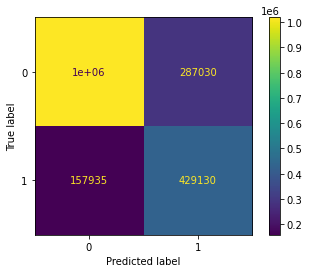

In [125]:
cm = confusion_matrix(y_train, train_cuttoff_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [126]:
print(classification_report(y_train, train_cuttoff_pred, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.87      0.78      0.82   1306373
       Obito       0.60      0.73      0.66    587065

    accuracy                           0.76   1893438
   macro avg       0.73      0.76      0.74   1893438
weighted avg       0.78      0.76      0.77   1893438



### Teste

In [127]:
# Add prediction probability to dataframe
test_cuttoff_pred = []

for i in y_proba_test:
    if i > threshold:
        i = 1
        test_cuttoff_pred.append(i)
    else:
        i = 0
        test_cuttoff_pred.append(i)

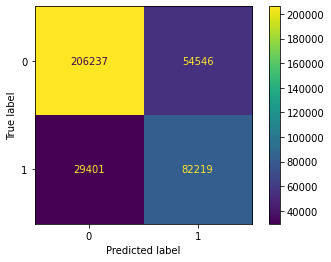

In [128]:
cm = confusion_matrix(y_test, test_cuttoff_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [129]:
print(classification_report(y_test, test_cuttoff_pred, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.88      0.79      0.83    260783
       Obito       0.60      0.74      0.66    111620

    accuracy                           0.77    372403
   macro avg       0.74      0.76      0.75    372403
weighted avg       0.79      0.77      0.78    372403

